# Gabor layer experiment

> In this quick experiment we will be training an MNIST classifier using multiple `GaussianLayer` layers.

In [1]:
#| hide
%load_ext autoreload
%autoreload 2

## Library importing

In [2]:
#| hide
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

from flayers.center_surround import GaussianLayer

## Data loading

> We will be using MNIST for a simple and quick test.

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = repeat(X_train, "b h w ->  b h w c", c=1)/255.0
X_test = repeat(X_test, "b h w ->  b h w c", c=1)/255.0

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

## Definition of simple model

In [5]:
filters = 4
sigma_i = [0.1, 0.2, 0.1, 0.1]
sigma_j = [0.2, 0.1, 0.2, 0.2]
freq = [10, 10]*2
theta = [0, np.pi/2, np.pi/4, -np.pi/4]
rot_theta = [0, 0]*2
sigma_theta = [0, 0, np.pi/4, -np.pi/4]

In [8]:
model = tf.keras.Sequential([
    GaussianLayer(filters=filters, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                  rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20, input_shape=(28,28,1)),
    layers.MaxPool2D(2),
    GaussianLayer(filters=filters, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                  rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20),
    layers.MaxPool2D(2),
    GaussianLayer(filters=filters, size=20, imean=0.5, jmean=0.5, sigma_i=sigma_i, sigma_j=sigma_j, freq=freq, 
                  rot_theta=rot_theta, sigma_theta=sigma_theta, fs=20),
    layers.MaxPool2D(2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

2022-10-03 11:35:31.221090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5
2022-10-03 11:35:33.699888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-03 11:35:33.913533: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x563c04957250


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_layer (GaussianLaye (None, 28, 28, 4)         1622      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
gaussian_layer_1 (GaussianLa (None, 14, 14, 4)         1622      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
gaussian_layer_2 (GaussianLa (None, 7, 7, 4)           1622      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 4)           0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0

We can show the initial Gabor filters:

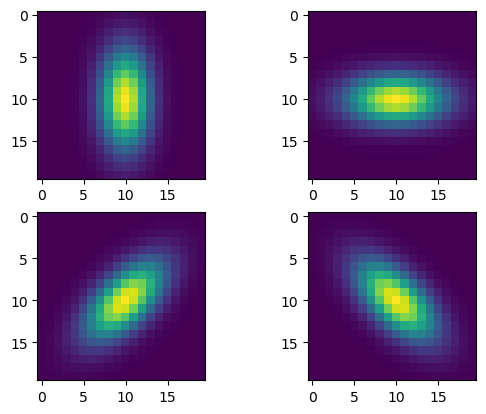

In [9]:
model.layers[0].show_filters()

In [10]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=2, validation_split=0.2)

Epoch 1/2


2022-10-03 11:35:54.860757: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-10-03 11:35:55.350367: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


375/375 [==============================] - 44s 82ms/step - loss: 305.9097 - accuracy: 0.1155 - val_loss: 7.6417 - val_accuracy: 0.1447
Epoch 2/2
375/375 [==============================] - 30s 79ms/step - loss: 7.0199 - accuracy: 0.1390 - val_loss: 5.8704 - val_accuracy: 0.1345


Showing the training dynamics:

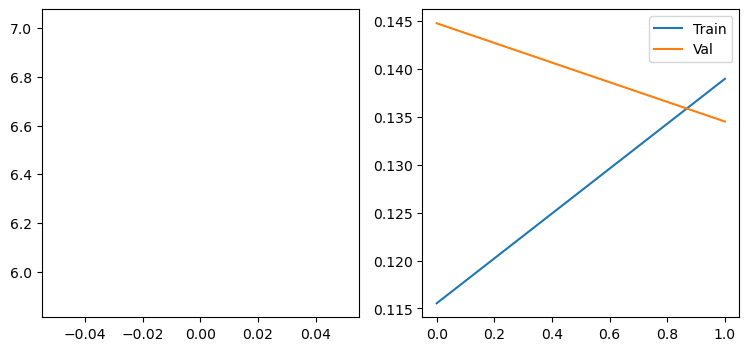

In [11]:
fig, axes = plt.subplots(1,2, figsize=(9,4))
axes[0].plot(history.history['loss'][1:], label="Train")
axes[0].plot(history.history['val_loss'][1:], label="Val")
axes[1].plot(history.history['accuracy'], label="Train")
axes[1].plot(history.history['val_accuracy'], label="Val")
plt.legend()
plt.show()

Calculate the metrics in the test set:

In [12]:
model.evaluate(X_test, Y_test, batch_size=128)

79/79 [==============================] - 0s 4ms/step - loss: 5.8667 - accuracy: 0.1332


[5.86668062210083, 0.133200004696846]

We can visualize the gabor filters after the training process:

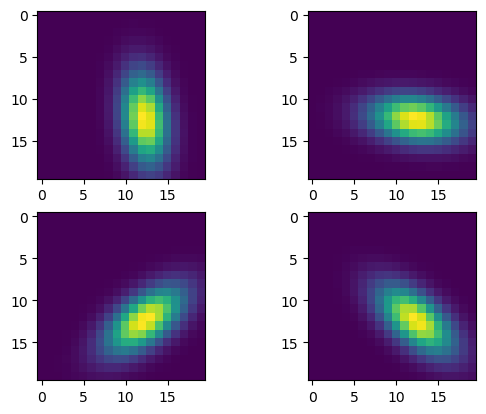

In [13]:
model.layers[0].show_filters()

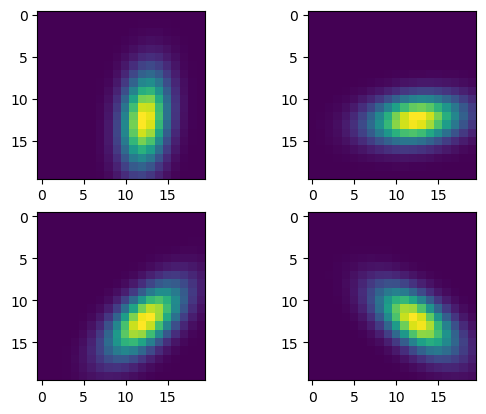

In [14]:
model.layers[2].show_filters()

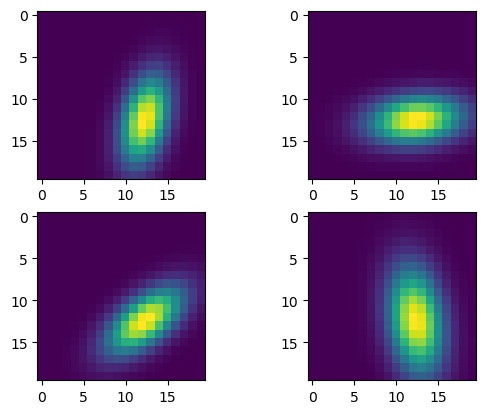

In [15]:
model.layers[4].show_filters()

We can even check the atributes of the layer to inspect the change in the initial parameters:

In [16]:
model.layers[0].rot_theta.numpy()*180/np.pi

array([ 3.463327 , -3.5490663, -3.748925 ,  2.1405466], dtype=float32)

In [17]:
model.layers[0].sigma_theta.numpy()*180/np.pi

array([ -3.463326,   3.549067,  48.748924, -47.14055 ], dtype=float32)